### Check *analytical* pipeline using blended by comparing results with CHIRPS outputs at the district level

In [1]:
%cd ../../

In [8]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd
import xskillscore as xss

from odc.geo.geobox import GeoBox

In [9]:
from helper_fns import read_observations_locally, read_forecasts_locally, aggregate_by_district
from config.params import Params
from analytical import calculate_forecast_probabilities, evaluate_forecast_probabilities, get_verification_df
from hip.analysis.analyses.drought import get_accumulation_periods
from hip.analysis.aoi import AnalysisArea

Prepare input data

In [4]:
fc = read_forecasts_locally('data/MOZ/forecast/Moz_SAB_tp_ecmwf_01/*.nc')

In [11]:
params = Params(iso='MOZ', index='SPI')
params.issue=1

In [10]:
obs = read_observations_locally(f"data/MOZ/chirps")
observations = read_observations_locally(f"AA/data/{params.iso}/chirps")
bbox = (30.12, -26.775, 40.7, -10.37)
geobox = GeoBox.from_bbox(bbox, crs="epsg:4326", resolution=0.25)
time_range = "1981-01-01/2023-05-31"

area = AnalysisArea(
    geobox=geobox,
    datetime_range=time_range,
)

blended = area.get_dataset(["CHIRPS", "rfh_blended_moz_25"])
observations = blended.sel(time=observations.time).rename({'daily_blended': 'precip'}).load()

INFO:root:['CHIRPS', 'rfh_blended_moz_25'],None,None,None not found, loading from source
INFO:root:get_dataset ZarrSatelliteProduct(key=['CHIRPS', 'rfh_blended_moz_25'], scale=1, offset=0, min_val=None, max_val=None, nodata=None, persist=False, path='https://data.earthobservation.vam.wfp.org/public-share/long_term_blending/MOZ/daily_blended_timesteps_25_bilint.zarr', alt_path='/s3/scratch/public-share/long_term_blending/MOZ/daily_blended_timesteps_25_bilint.zarr', aws_account_alias='HDC')
INFO:root:load_dataset ZarrSatelliteProduct(key=['CHIRPS', 'rfh_blended_moz_25'], scale=1, offset=0, min_val=None, max_val=None, nodata=None, persist=False, path='https://data.earthobservation.vam.wfp.org/public-share/long_term_blending/MOZ/daily_blended_timesteps_25_bilint.zarr', alt_path='/s3/scratch/public-share/long_term_blending/MOZ/daily_blended_timesteps_25_bilint.zarr', aws_account_alias='HDC'), GeoBox((67, 43), Affine(0.25, 0.0, 30.0,
       0.0, -0.25, -10.25), CRS('EPSG:4326')), 1981-01-01/

In [12]:
triggers_df = pd.read_csv(f"data/{params.iso}/outputs/Plots/triggers.aa.python.spi.dryspell.2022.csv")
gdf = gpd.read_file(f"data/{params.iso}/shapefiles/moz_admbnda_2019_SHP/moz_admbnda_adm2_2019.shp")

In [13]:
accumulation_periods = get_accumulation_periods(
    fc, 
    params.start_season,
    params.end_season,
    params.min_index_period, 
    params.max_index_period
)
accumulation_periods
period = accumulation_periods['AM']

In [14]:
fc = fc.where(fc.time < np.datetime64('2022-07-01T12:00:00.000000000'), drop=True)

Test functions for ```calculate_forecast_probabilities``` and ```evaluate_forecast_probabilities```

In [15]:
params.year = 2022

In [16]:
def get_test_input(month="01"):
    np.random.seed(42)
    test_input_fc = xr.Dataset(
        data_vars=dict(
            tp=(["time", "ensemble", "longitude", "latitude"], np.random.rand(len(range(1993, 2022)) * 31, 5, 3, 3)),
        ),
        coords = dict(
            time=pd.concat([pd.Series(pd.date_range(f"{yyyy}-{month}-01", f"{yyyy}-{month}-31")) for yyyy in range(1993, 2022)]),
            ensemble=range(5),
            longitude=[-1, 0, 1],
            latitude=[-1, 0, 1],
        )
    )
    test_input_obs = xr.Dataset(
        data_vars=dict(precip=(["time", "longitude", "latitude"], np.random.rand(len(range(1993, 2022)) * 31, 3, 3))),
        coords = dict(
            time=pd.concat([pd.Series(pd.date_range(f"{yyyy}-{month}-01", f"{yyyy}-{month}-31")) for yyyy in range(1993, 2022)]),
            longitude=[-1, 0, 1],
            latitude=[-1, 0, 1],
        )
    )
    test_input_probas = xr.Dataset(
        data_vars=dict(tp=(["year"], np.random.rand(len(range(1993, 2022))))),
        coords = dict(year=range(1993, 2022))
    )
    np.random.seed(43)
    test_input_probas_bc = xr.Dataset(
        data_vars=dict(scen=(["year"], np.random.rand(len(range(1993, 2022))))),
        coords = dict(year=range(1993, 2022))
    )
    test_input_levels = xr.Dataset(
        data_vars=dict(precip=(["year"], np.random.randint(0, 2, len(range(1993, 2022))))),
        coords = dict(year=range(1993, 2022))
    )
    return test_input_fc, test_input_obs, test_input_probas, test_input_probas_bc, test_input_levels

In [17]:
def test_calculate_forecast_probabilities():
    np.random.seed(42)
    test_input_fc1, test_input_obs1, _, _, _ = get_test_input("01")
    probabilities_a, bc_a, _, levels_obs_a = calculate_forecast_probabilities(test_input_fc1, test_input_obs1, params, (1), 1) 
    probabilities_b, bc_b, _, levels_obs_b = calculate_forecast_probabilities(test_input_fc1, test_input_obs1, params, (1), 12) 
    
    ref_probas_month1 = xr.DataArray(
        np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.13333333, 0.2, 0.2, 0.4, 0.2, 0., 0.06666667, 0., 0.2, 0.33333333, 0., 0.2, 0.2, 0.13333333, 0.2, 0.6, 0, 0.6, 0.33333333, 0.2, 0.2, 0.26666667, 0.13333333, 0.]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))
    ref_bc_month1_issue1 = xr.DataArray(
        np.array([0.2, 0.26666667, 0.2, 0.33333333, 0.2, 0.06666667, 0.26666667, 0.2, 0.4, 0.26666667, 0., 0.06666667, 0., 0.2, 0.26666667, 0.06666667, 0.2, 0.13333333, 0.2, 0.2, 0.73333333, 0., 0.6, 0.33333333, 0.2, 0.2, 0.26666667, 0.2, 0.]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))
    ref_bc_month1_issue12 = xr.DataArray(
        np.array([0.13333333, 0.26666667, 0.2, 0.13333333, 0.2, 0.2 , 0.26666667, 0.2 , 0.4, 0.26666667, 0., 0.06666667, 0., 0.2, 0.4, 0., 0.2, 0.2, 0.26666667, 0.2, 0.66666667, 0., 0.6, 0.46666667, 0.2, 0.2, 0.33333333, 0.2, 0]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))
    ref_obs_month1 = xr.DataArray(
        np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.66666667, 0, 0, 1, 0, 1, 0.33333333, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.33333333]),
        coords=dict(year=range(1993, 2022))
    ).assign_coords(dict(longitude=0, latitude=0))

    xr.testing.assert_allclose(probabilities_a.sel(latitude=0, longitude=0).mean('category').tp, ref_probas_month1)
    xr.testing.assert_allclose(probabilities_b.sel(latitude=0, longitude=0).mean('category').tp, ref_probas_month1)

    xr.testing.assert_allclose(bc_a.sel(latitude=0, longitude=0).mean('category').scen, ref_bc_month1_issue1)
    xr.testing.assert_allclose(bc_b.sel(latitude=0, longitude=0).mean('category').scen, ref_bc_month1_issue12)
    
    xr.testing.assert_allclose(levels_obs_a.sel(latitude=0, longitude=0).mean('category').precip, ref_obs_month1)
    xr.testing.assert_allclose(levels_obs_b.sel(latitude=0, longitude=0).mean('category').precip, ref_obs_month1)

    print("\nFORECASTS PROBABILITIES TESTS PASSED")
ref_probas_month1_issue1 = test_calculate_forecast_probabilities()

INFO:root:Completed accumulation
INFO:root:Completed anomaly
INFO:root:Completed accumulation
INFO:root:Completed anomaly



FORECASTS PROBABILITIES TESTS PASSED


In [18]:
def test_evaluate_forecast_probabilities():
    _, _, test_probas, test_probas_bc, test_obs_levels = get_test_input()
    test_auc, test_auc_bc = evaluate_forecast_probabilities(test_probas, test_probas_bc, test_obs_levels)

    xr.testing.assert_allclose(test_auc, xr.DataArray(0.45192308))
    xr.testing.assert_allclose(test_auc_bc, xr.DataArray(0.19230769))

    print("\nFORECASTS VERIFICATION TESTS PASSED")

test_evaluate_forecast_probabilities()


FORECASTS VERIFICATION TESTS PASSED


### Comparison on the full output at the district level

In [25]:
def plot_hist(comparison, title, xlabel, xmin, xmax, s=1, mask_text=False):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize = (6,4))

    quant_5, quant_25, quant_50, quant_75, quant_95 = comparison.difference.quantile(0.05), comparison.difference.quantile(0.25), comparison.difference.quantile(0.5), comparison.difference.quantile(0.75), comparison.difference.quantile(0.95)

    # [quantile, opacity, length]
    quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

    comparison.difference.plot(kind='hist', density = True, alpha = 0.65, bins=200)
    comparison.difference.plot(kind='kde')

    # Plot the lines with a loop
    import matplotlib.pyplot as plt
    for i in quants: plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel(xlabel)
    ax.set_xlim(xmin, xmax) 

    # Y
    ax.set_yticklabels([])
    ax.set_ylabel("")

    if not(mask_text):
        plt.text(quant_5-.01, 0.15 * s, "5th", size = 10, alpha = 0.8)
        plt.text(quant_25-.013, 0.27 * s, "25th", size = 11, alpha = 0.85)
        plt.text(quant_50-.013, 0.33 * s, "50th", size = 12, alpha = 1)
        plt.text(quant_75-.013, 0.39 * s, "75th", size = 11, alpha = 0.85)
        plt.text(quant_95-.025, 0.47 * s, "95th Percentile", size = 10, alpha =.8)

    # Overall
    ax.grid(False)
    ax.set_title(title, size = 17, pad = 10)

    # Remove ticks and spines
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

In [64]:
fbfref = pd.read_csv('data/MOZ/outputs/Districts_FbF/spi/fbf.districts.roc.spi.2022.txt')
fbfref.columns = ['district', 'category', 'AUC_ref', 'BC_ref', 'Index', 'issue']
fbfref

,district,category,AUC_ref,BC_ref,Index,issue
0,Chiure,Severo,0.689008,1,SPI ON,5
1,Chiure,Moderado,0.654034,1,SPI ON,5
2,Chiure,Leve,0.590502,1,SPI ON,5
3,Chibuto,Severo,0.705415,0,SPI ON,5
4,Chibuto,Moderado,0.719236,0,SPI ON,5
...,...,...,...,...,...,...
2239,Changara,Moderado,0.708767,0,SPI MAM,2
2240,Changara,Leve,0.726175,0,SPI MAM,2
2241,Marara,Severo,0.710266,0,SPI MAM,2
2242,Marara,Moderado,0.708576,0,SPI MAM,2


In [20]:
fbfP = pd.read_csv('data/MOZ/outputs/Districts_FbF/spi/fbf.districts.roc.spi.2022.blended.txt')
fbfP

,district,category,AUC_best,BC,Index,issue
0,Chiure,Severo,0.526597,1,SPI ON,5
1,Chiure,Moderado,0.601572,1,SPI ON,5
2,Chiure,Leve,0.593102,1,SPI ON,5
3,Chibuto,Severo,0.551216,0,SPI ON,5
4,Chibuto,Moderado,0.581110,0,SPI ON,5
...,...,...,...,...,...,...
2239,Changara,Moderado,0.661446,0,SPI MAM,2
2240,Changara,Leve,0.671600,0,SPI MAM,2
2241,Marara,Severo,0.636880,0,SPI MAM,2
2242,Marara,Moderado,0.727053,0,SPI MAM,2


Ratio of bias-corrected values in the final output

In [21]:
# Ratio of cases using Bias Correction
fbfP.BC.sum() / len(fbfP)

0.16310160427807488

Histogram of difference between full outputs

In [65]:
comparison = fbfP.set_index(['district', 'category', 'Index', 'issue']).join(fbfref.set_index(['district', 'category', 'Index', 'issue'])).reset_index()

In [67]:
comparison['difference'] = comparison.AUC_best - comparison.AUC_ref

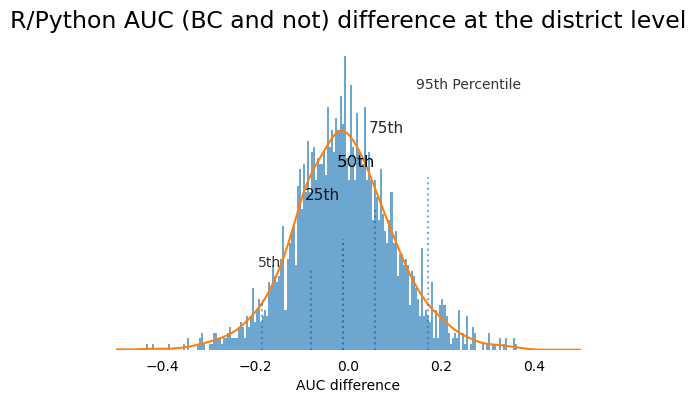

In [68]:
plot_hist(comparison, title="R/Python AUC (BC and not) difference at the district level", xlabel="AUC difference", xmin=-.5, xmax=.5, s=10)

### Difference (Blended - CHIRPS) on the full output by category / district / index / issue

Text(0.5, 0.98, 'SEVERE CATEGORY')

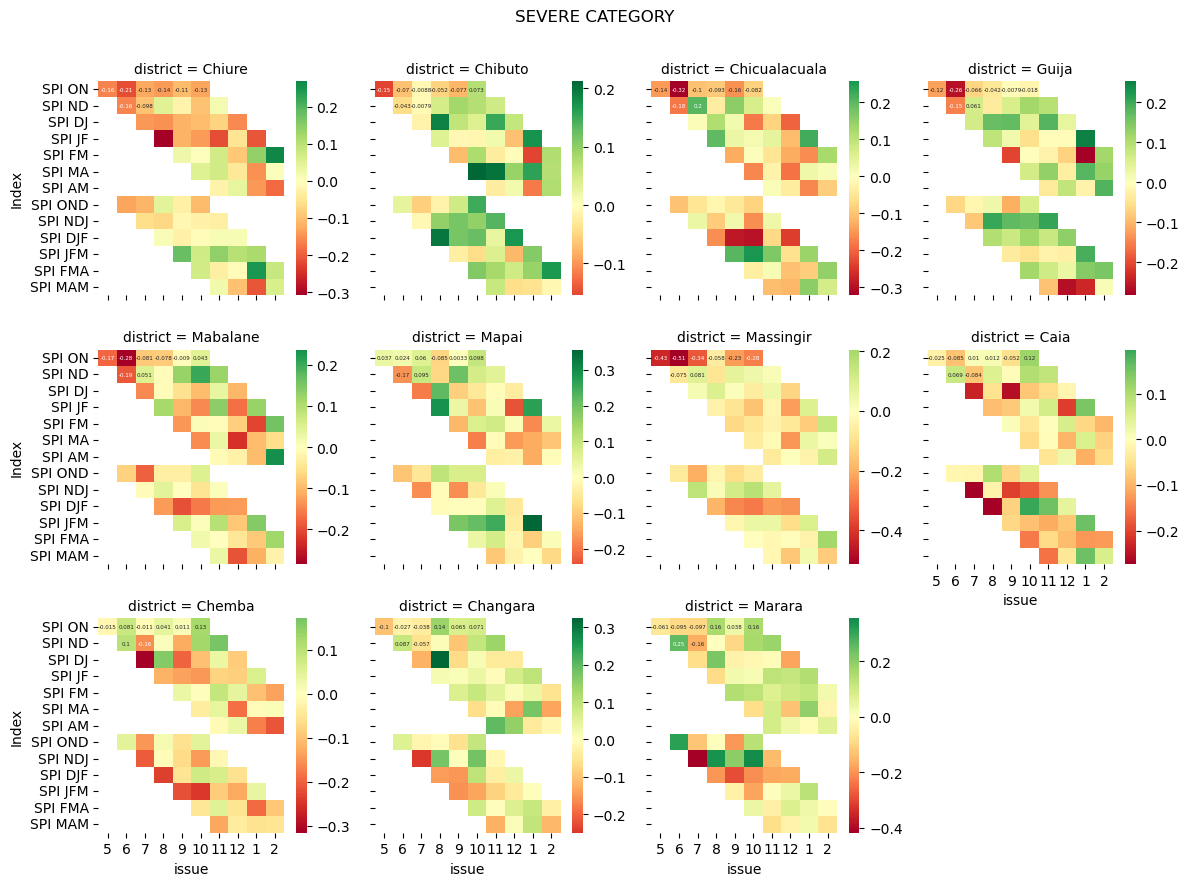

In [69]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(comparison.loc[(comparison.category=='Severo')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('SEVERE CATEGORY')

Text(0.5, 0.98, 'MODERATE CATEGORY')

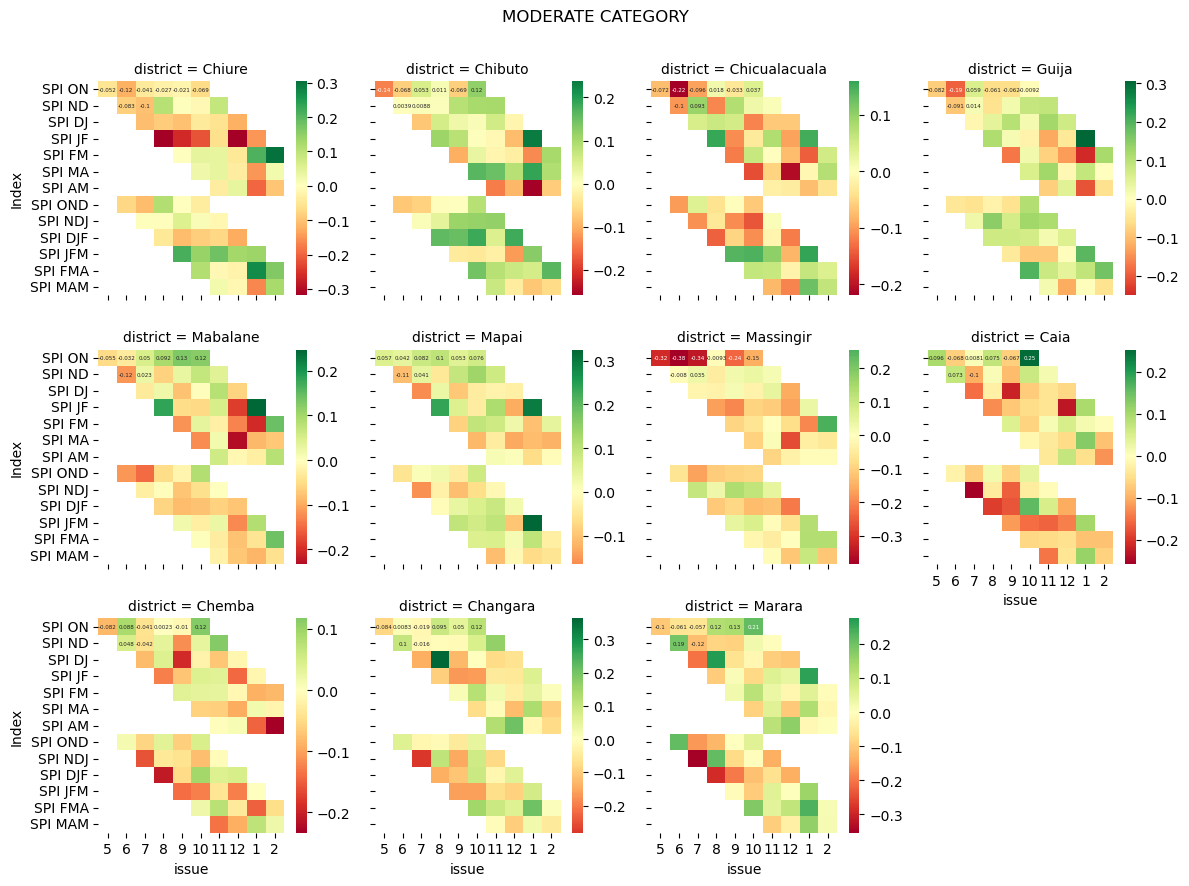

In [70]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Moderado')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MODERATE CATEGORY')

Text(0.5, 0.98, 'MILD CATEGORY')

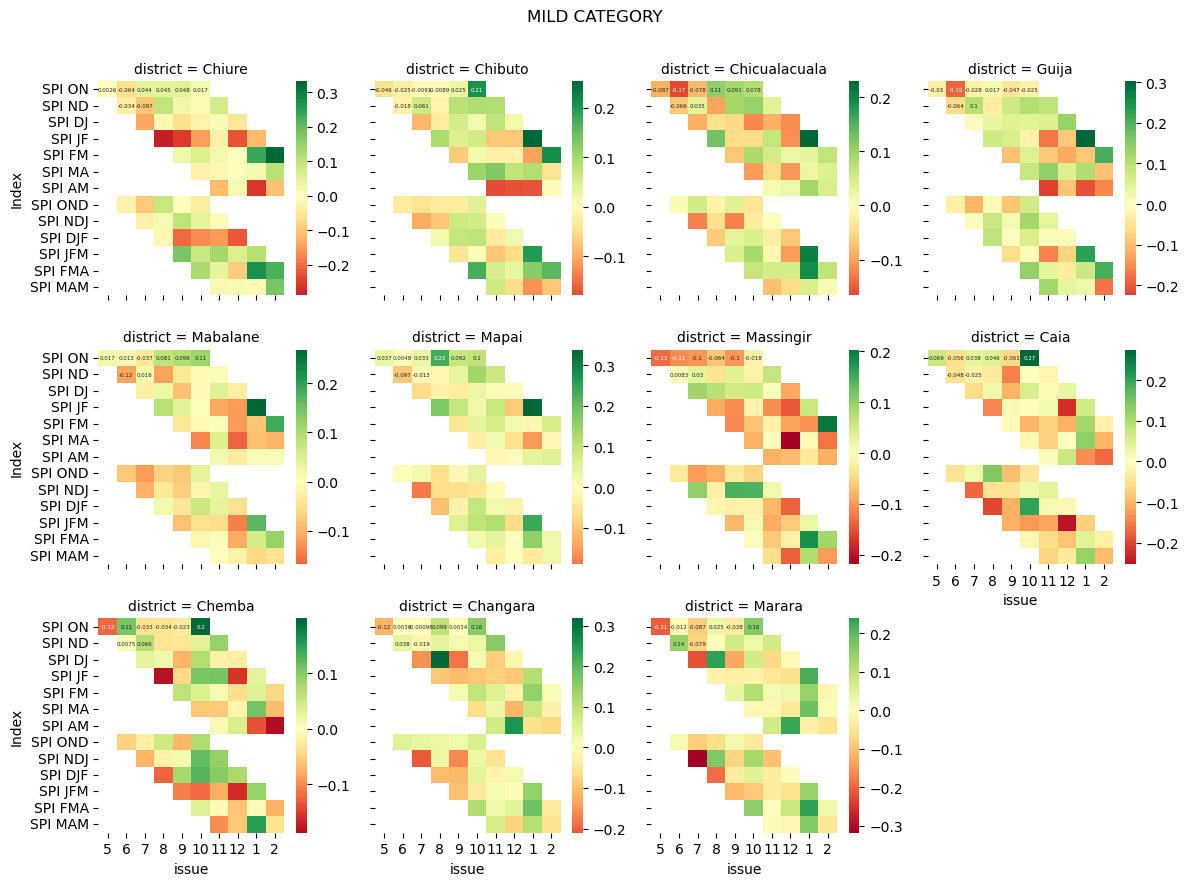

In [71]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Leve')], col='district', col_wrap=4)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MILD CATEGORY')

### Visualisation of differences for each pair of variables to highlight any systematic errors in the Python script

**Average difference**

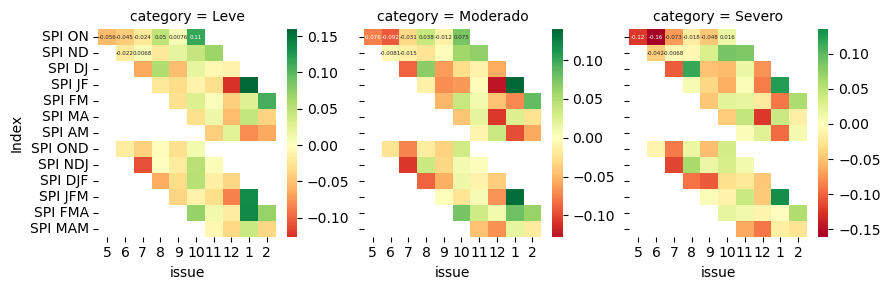

In [72]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'Index', 'category']).mean('district').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

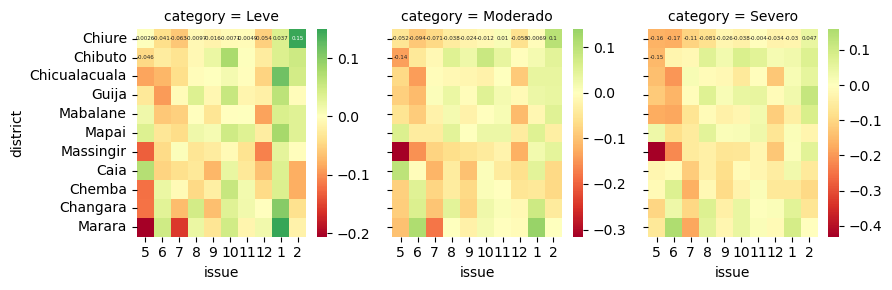

In [73]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'district', 'category']).mean('Index').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

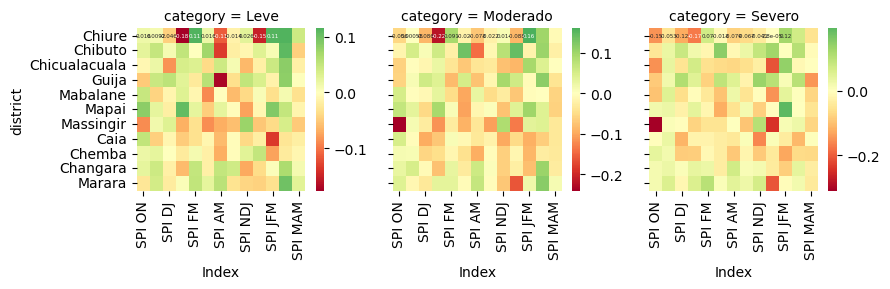

In [74]:
x_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM']
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="Index", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['Index', 'district', 'category']).mean('issue').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

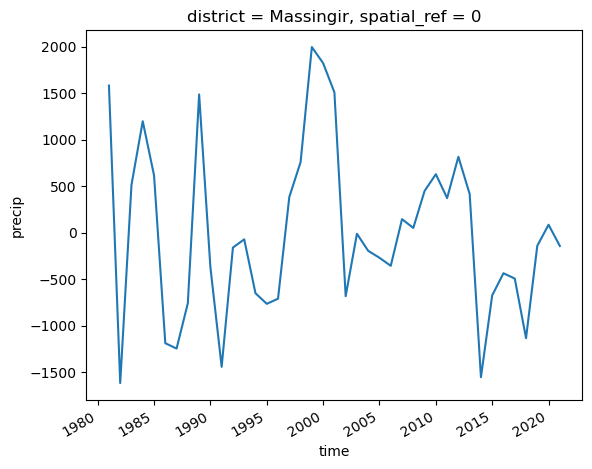

In [52]:
xr.open_zarr("AA/data/MOZ/outputs/zarr/obs/2022/SPI ON/observations.zarr").sel(district='Massingir').precip.plot.line()

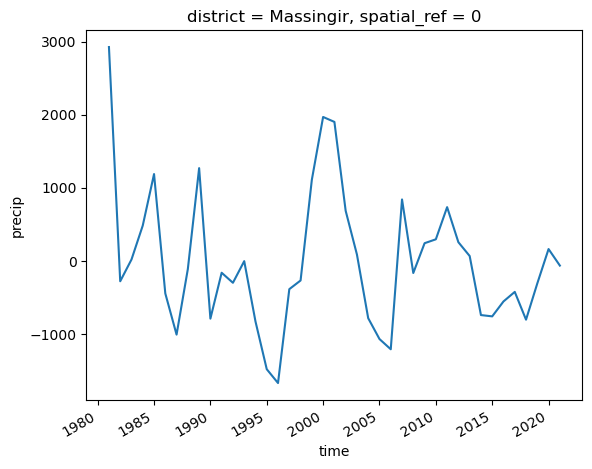

In [53]:
xr.open_zarr("AA/data/MOZ/outputs/zarr/obs/2022_blended/SPI ON/observations.zarr").sel(district='Massingir').precip.plot.line()